# 影像分割(Image Segmentation)

# 程式參考來源：
https://keras.io/examples/vision/oxford_pets_image_segmentation/

## 下載資料
- 原圖：http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
- 註解：http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

## 取得原圖及目標圖遮罩(Mask)的檔案路徑

In [12]:
import os

# 原圖目錄位置
input_dir = "./ImageSegmentData/images/"
# 目標圖遮罩(Mask)的目錄位置
target_dir = "./ImageSegmentData/annotations/trimaps/"

# 超參數
img_size = (160, 160)
num_classes = 4
batch_size = 32

# 取得原圖檔案路徑
input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)

# 取得目標圖遮罩的檔案路徑
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("樣本數:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

樣本數: 7390
./ImageSegmentData/images/Abyssinian_1.jpg | ./ImageSegmentData/annotations/trimaps/Abyssinian_1.png
./ImageSegmentData/images/Abyssinian_10.jpg | ./ImageSegmentData/annotations/trimaps/Abyssinian_10.png
./ImageSegmentData/images/Abyssinian_100.jpg | ./ImageSegmentData/annotations/trimaps/Abyssinian_100.png
./ImageSegmentData/images/Abyssinian_101.jpg | ./ImageSegmentData/annotations/trimaps/Abyssinian_101.png
./ImageSegmentData/images/Abyssinian_102.jpg | ./ImageSegmentData/annotations/trimaps/Abyssinian_102.png
./ImageSegmentData/images/Abyssinian_103.jpg | ./ImageSegmentData/annotations/trimaps/Abyssinian_103.png
./ImageSegmentData/images/Abyssinian_104.jpg | ./ImageSegmentData/annotations/trimaps/Abyssinian_104.png
./ImageSegmentData/images/Abyssinian_105.jpg | ./ImageSegmentData/annotations/trimaps/Abyssinian_105.png
./ImageSegmentData/images/Abyssinian_106.jpg | ./ImageSegmentData/annotations/trimaps/Abyssinian_106.png
./ImageSegmentData/images/Abyssinian_107.jpg | ./Im

## 顯示其中一張圖

./ImageSegmentData/images/Abyssinian_107.jpg


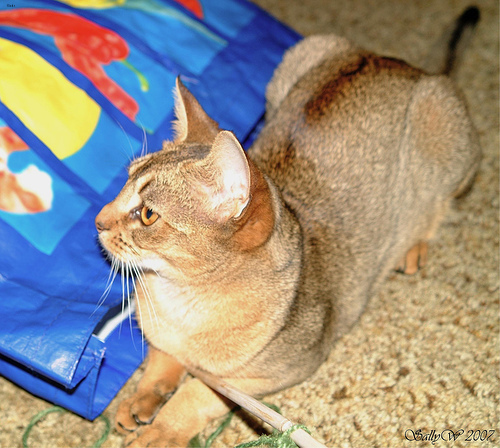

./ImageSegmentData/annotations/trimaps/Abyssinian_107.png


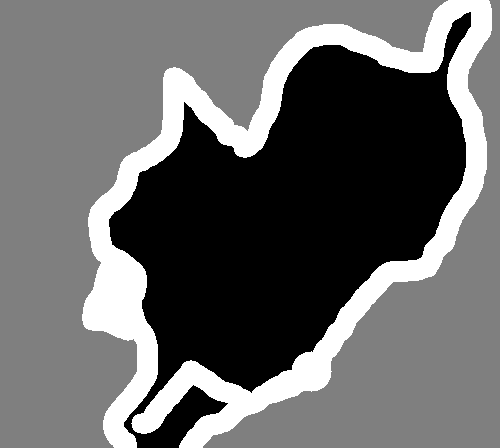

In [13]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

# 顯示第10張圖
print(input_img_paths[9])
display(Image(filename=input_img_paths[9]))

# 調整對比，將最深的顏色當作黑色(0)，最淺的顏色當作白色(255)
print(target_img_paths[9])
img = PIL.ImageOps.autocontrast(load_img(target_img_paths[9]))
display(img)

## 定義批次讀取影像的類別，一次傳回一批影像

In [14]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img


class OxfordPets(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
        return x, y


## 建立 U-Net 模型

In [15]:
from tensorflow.keras import layers

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 80, 80, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 80, 80, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 80, 80, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

# 繪製模型結構

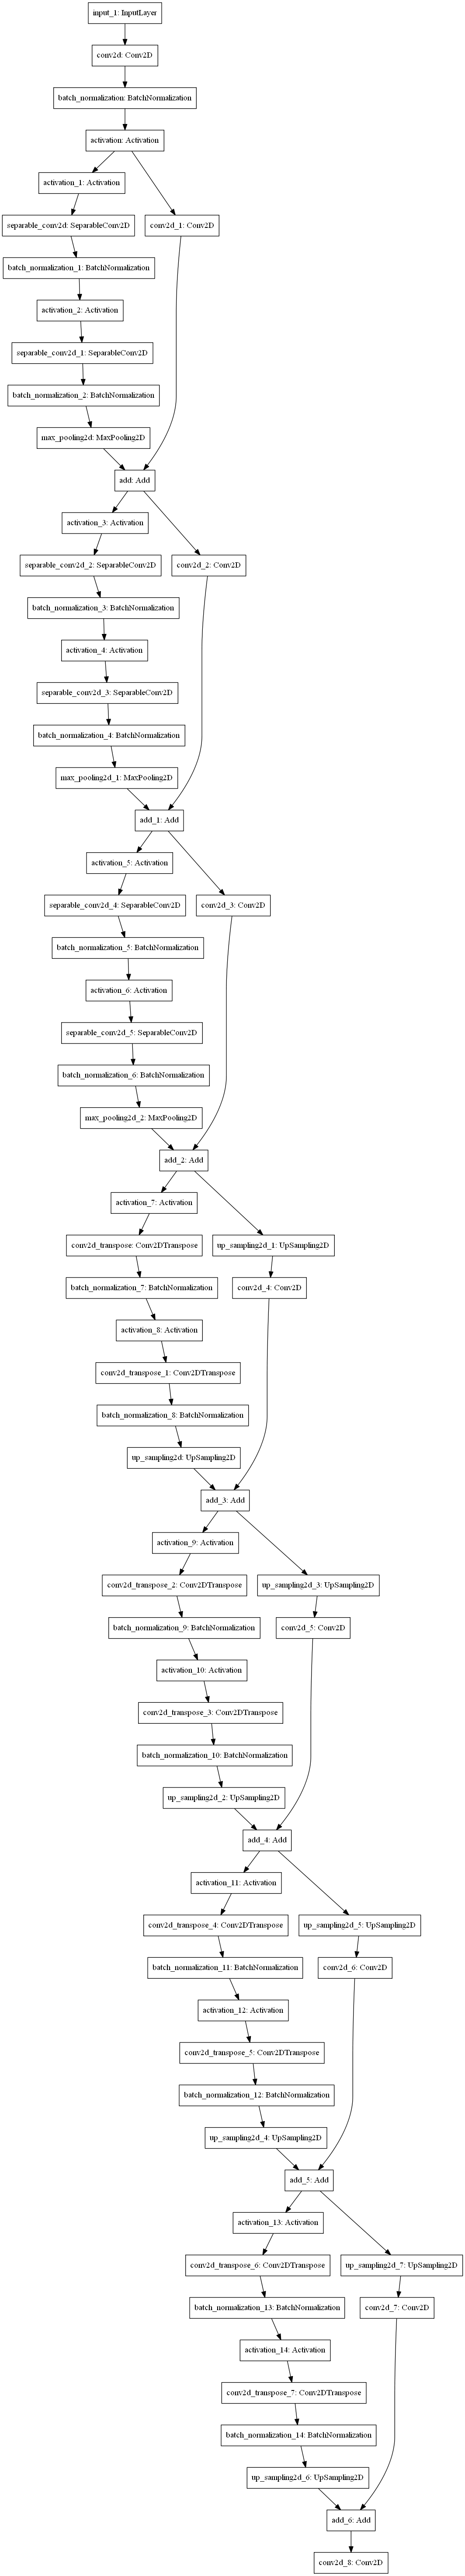

In [16]:
import tensorflow as tf
tf.keras.utils.plot_model(model, to_file='Unet_model.png')

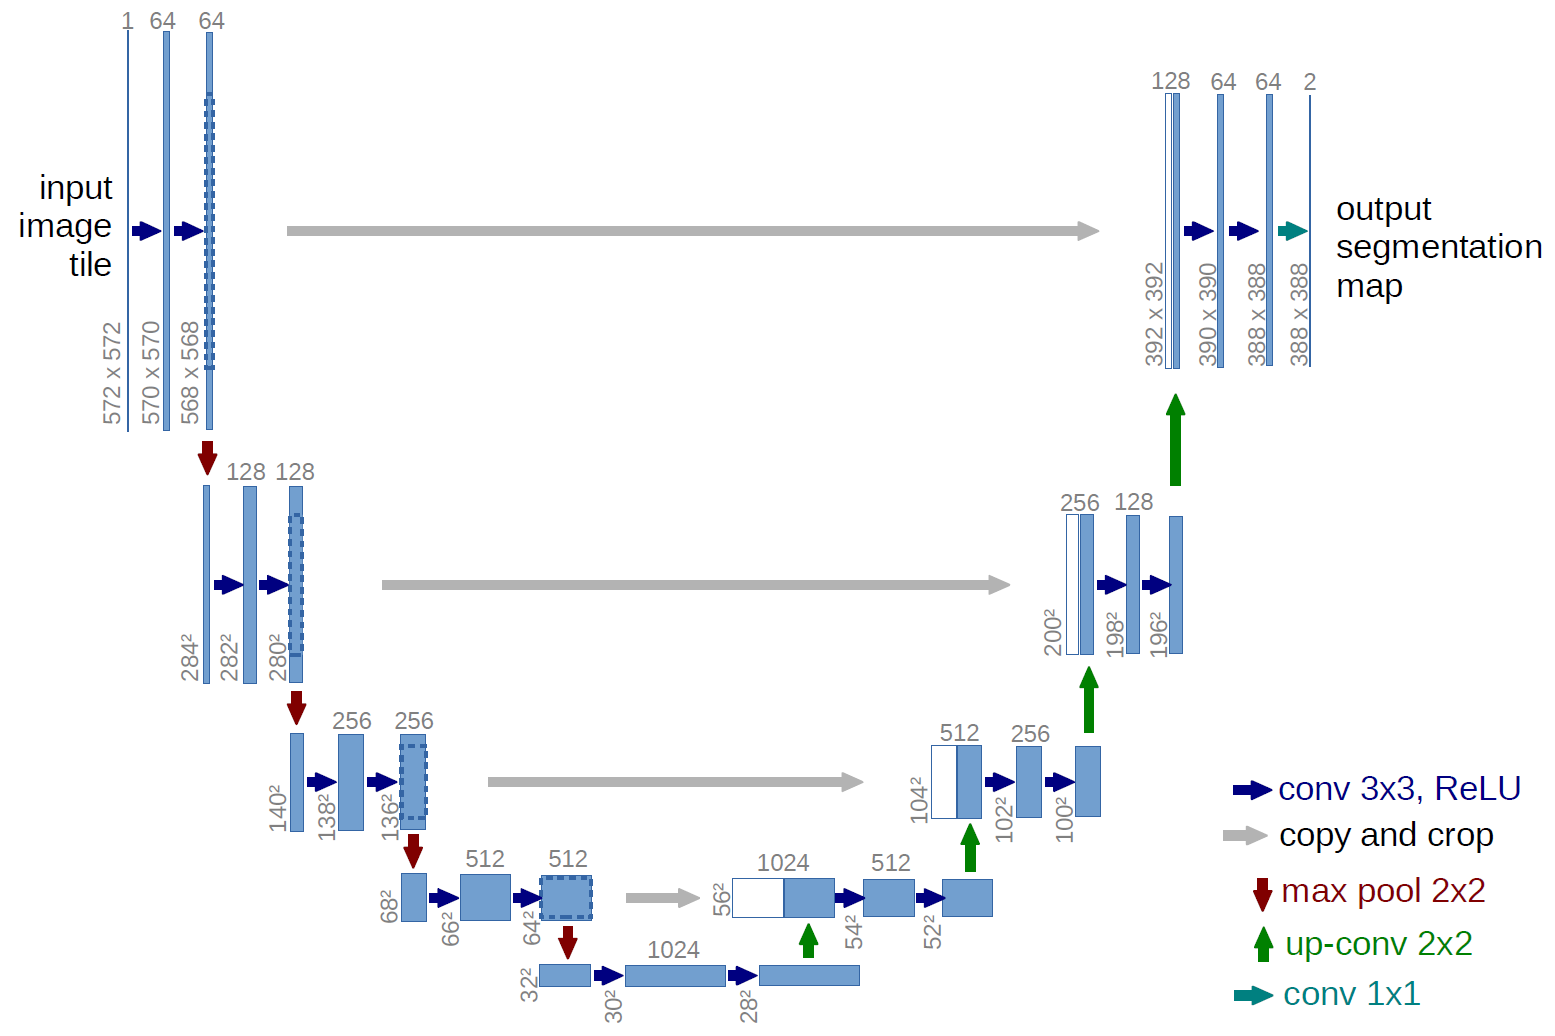

In [17]:
# 圖片來源：https://github.com/zhixuhao/unet
from IPython.display import Image
Image('0_images/u-net-architecture.png', width=500)

## 將資料切割為訓練及驗證資料

In [18]:
import random

# Split our img paths into a training and a validation set
val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = OxfordPets(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)

## 訓練模型

In [19]:
# 設定優化器(optimizer)、損失函數(loss)、效能衡量指標(metrics)的類別
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

# 設定檢查點 callbacks，模型存檔
callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)
]

# 訓練 15 週期(epoch)
epochs = 15
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)


Epoch 1/15
199/199 [==============================] - 152s 762ms/step - loss: 1.1468 - val_loss: 3.1801
Epoch 2/15
199/199 [==============================] - 88s 441ms/step - loss: 0.5093 - val_loss: 2.4926
Epoch 3/15
199/199 [==============================] - 88s 442ms/step - loss: 0.4305 - val_loss: 0.4305
Epoch 4/15
199/199 [==============================] - 88s 442ms/step - loss: 0.4047 - val_loss: 0.4476
Epoch 5/15
199/199 [==============================] - 89s 448ms/step - loss: 0.3523 - val_loss: 0.3957
Epoch 6/15
199/199 [==============================] - 89s 446ms/step - loss: 0.3244 - val_loss: 0.3746
Epoch 7/15
199/199 [==============================] - 89s 445ms/step - loss: 0.2966 - val_loss: 0.4087
Epoch 8/15
199/199 [==============================] - 89s 445ms/step - loss: 0.2750 - val_loss: 0.3875
Epoch 9/15
199/199 [==============================] - 88s 444ms/step - loss: 0.2566 - val_loss: 0.4078
Epoch 10/15
199/199 [==============================] - 89s 448ms/step - 

## 顯示結果

原圖


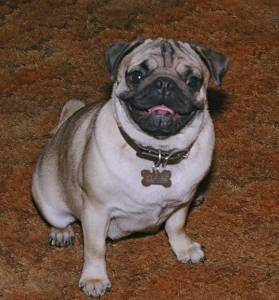

原圖遮罩


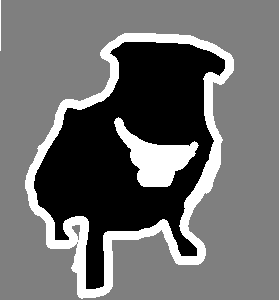

結果


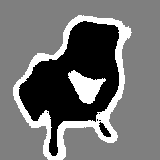

In [20]:
# 預測所有驗證資料
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)


# 顯示遮罩(mask)
def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


# 顯示驗證資料第11個圖檔
i = 10
# 顯示原圖
print('原圖')
display(Image(filename=val_input_img_paths[i]))

# 顯示原圖遮罩(mask)
print('原圖遮罩')
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# 顯示預測結果
print('結果')
display_mask(i)  # Note that the model only sees inputs at 150x150.